In [1]:
# !pip install pyod

In [2]:
%reload_ext autoreload
%autoreload 2

import sys, os, time
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
import warnings

from RejEx import *

def ignore_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    warnings.simplefilter(action='ignore', category=DeprecationWarning)
ignore_warnings()

### Create the Toy Dataset

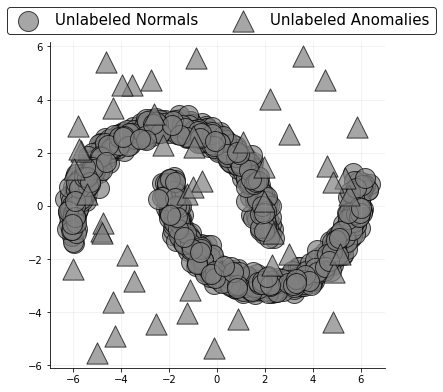

In [3]:
def create_ds(N, seed):
    np.random.seed(seed)
    contamination = 0.05
    num_anom = int(N*contamination)
    X = 4.0*(make_moons(n_samples=N-num_anom, noise=0.05, random_state=seed)[0]- np.array([0.5, 0.25]))
    X = np.concatenate([X, np.random.uniform(low=-6, high=6, size=(num_anom, 2))], axis=0)
    y = np.zeros(N, dtype=np.int)
    y[-num_anom:] = 1
    return X, y


X, y = create_ds(N = 1000, seed = 1)
n = len(y)
fig = plt.figure(figsize=(6,6), facecolor='w', edgecolor='k')
normals = X[np.where(y==0)[0],:]
anomalies = X[np.where(y==1)[0],:]
contamination = sum(y)/len(y)

cl0 = plt.scatter(normals.T[0],normals.T[1], 400, c = 'gray', alpha = 0.7, edgecolor = 'black',
                  label = 'Unlabeled Normals')
cl1 = plt.scatter(anomalies.T[0],anomalies.T[1], 450, c = 'gray', marker = '^',edgecolor = 'black',
                  alpha = 0.7, label = 'Unlabeled Anomalies')
plt.legend(loc='upper left',
           bbox_to_anchor=(-0.15, 1.13),
           ncol=2,
           fontsize=15,frameon=True).get_frame().set_edgecolor('black')
sns.despine(right = True)
plt.grid(alpha = 0.2)
plt.show()

## Standard Anomaly Detection without Rejection

In [4]:
c_fp,c_fn = 1,1 #costs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
ad = IForest(contamination = contamination).fit(X_train)
y_pred = ad.predict(X_test)
tp, tn, fp, fn = confusion_matrix(y_pred, y_test)
cost_plain = np.round((fp*c_fp + fn*c_fn)/len(y_test),4)
print("The detector obtains a cost per example of:", cost_plain)

The detector obtains a cost per example of: 0.048


## RejEx: *Rej*ecting via *Ex*CeeD

### Computing the Confidence Metric

In [5]:
T = 32               #thr = 1- 2*np.exp(-T) is the rejection threshold
c_r = contamination  # we set the rejection cost to as much as possible

### Introducing the Reject Option

In [6]:
# In case of rejection, the model's prediction is -2.
predictions_with_rejection = predict_with_RejEx(ad, X_test, T, contamination)

#Overall performance (cost-based)
cost_with_rejection = evaluate_model_with_rejection(predictions_with_rejection, y_test, c_fp, c_fn, c_r)
print("The PLAIN detector (No-Rejection) obtains a cost per example of:", cost_plain)
print("---> Using RejEx makes the detector obtain a cost per example of:", cost_with_rejection)

The PLAIN detector (No-Rejection) obtains a cost per example of: 0.048
---> Using RejEx makes the detector obtain a cost per example of: 0.0276


### Theoretical Results

In [7]:
n_train = len(X_train)

estimate_rr = expected_rejection_rate(n_train, contamination, T)
empirical_rejection_rate = len(np.where(predictions_with_rejection==-2)[0])/len(y_test)

delta = 0.10
theory_ub_rr = get_upper_bound_rr(n_train, contamination, T, delta)

up_exp_cost = upperbound_cost(n_train, contamination, T, c_fp, c_fn, c_r)

print("Theoretical rejection rate estimate:",np.round(estimate_rr,3))
print("Actual test rejection rate:", np.round(empirical_rejection_rate,3))
print("Theoretical rejection rate upper bound:", np.round(theory_ub_rr,3))
print("\n")

print("Theoretical cost upper bound:", np.round(up_exp_cost,3))
print("Empirical cost:", cost_with_rejection)

Theoretical rejection rate estimate: 0.122
Actual test rejection rate: 0.152
Theoretical rejection rate upper bound: 0.276


Theoretical cost upper bound: 0.066
Empirical cost: 0.0276


## Visualize ExCeeD's stability-based confidence metric

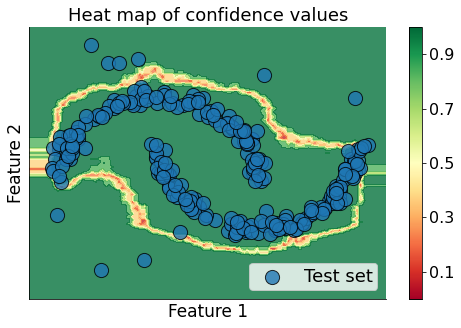

In [8]:
plt.figure(figsize=(8,5))
steps=150
margin_size=0.1

# ranges
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
x_range = abs(x_max - x_min)
y_range = abs(y_max - y_min)

xmin, xmax = x_min - margin_size * x_range, x_max + margin_size * x_range
ymin, ymax = y_min - margin_size * y_range, y_max + margin_size * y_range

# make the meshgrid based on the data 
xx, yy = np.meshgrid(np.linspace(xmin, xmax, int(steps)),np.linspace(ymin, ymax, int(steps)))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

# fit and predict the classifier
test_scores = ad.decision_function(X_mesh)
train_scores = ad.decision_function(X_train)
heatmapconfidence, _ = pred_confidence(ad, X_mesh)

Z = heatmapconfidence.reshape(xx.shape)
#plt.title("Example-Wise Confidence by ExCeeD", fontsize= 14)

# plot the contour
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn,norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1),alpha=0.8,
            linewidths = 1)
plt.title("Heat map of confidence values", fontsize = 18)
plt.xlabel("Feature 1", fontsize = 17)
plt.ylabel("Feature 2", fontsize = 17)

#add the blue points
np.random.seed(331)
lbl1 = plt.scatter(X_test[:, 0], X_test[:, 1], s=200, edgecolors='k', alpha = 0.8, label = 'Test set')
plt.xlim(-7.1,7.1)
plt.ylim(-6.2,6.2)
plt.xticks([])
plt.yticks([])

plt.legend(fontsize = 18,loc = 'lower right', borderpad=.25)

ax, _ = matplotlib.colorbar.make_axes(plt.gca(), shrink=1.0)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.RdYlGn,
                                        norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1),
                                        ticks = np.arange(10,95,20)/100)
cbar.ax.tick_params(labelsize=16)
sns.despine()
plt.show()